
# Generating Names with a Character-Level RNN



### Preparing the Data

Download the data in folder `data/names` from GitHub.

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

In [1]:
import string
import unicodedata

# these is the vocabulary we will use
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(f"Vocab is of size {n_letters} and contains:", all_letters)

Vocab is of size 57 and contains: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [2]:
# we convert anything into ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('Heute ist es schön heiß'))

Slusarski
Heute ist es schon hei


In [3]:
from io import open
import glob
import os

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

all_categories = []
category_lines = {}

for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
n_categories

18

### Creating the Network

This network extends the RNN from last week 
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

There is  a second linear layer ``o2o`` (after combining hidden and
output) to give it more power to work with.

In [4]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

The category tensor is a one-hot tensor of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [5]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [6]:
import random

# Get a random category and random line from that category
def randomTrainingPair():
    category = random.choice(all_categories)
    lines = category_lines[category]
    line = random.choice(lines)
    return category, line

In [7]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [8]:
rnn = RNN(n_letters, 128, n_letters)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 7s (5000 5%) 3.9955
0m 15s (10000 10%) 3.0220
0m 22s (15000 15%) 1.7078
0m 30s (20000 20%) 1.6721
0m 37s (25000 25%) 1.8973
0m 45s (30000 30%) 1.7972
0m 53s (35000 35%) 2.3314
1m 1s (40000 40%) 1.8625
1m 8s (45000 45%) 1.1585
1m 16s (50000 50%) 1.3261
1m 25s (55000 55%) 1.8772
1m 33s (60000 60%) 2.8528
1m 42s (65000 65%) 2.2551
1m 50s (70000 70%) 1.5979
1m 57s (75000 75%) 2.0633
2m 4s (80000 80%) 1.3458
2m 12s (85000 85%) 2.7514
2m 20s (90000 90%) 2.8645
2m 28s (95000 95%) 2.0310
2m 36s (100000 100%) 1.5522


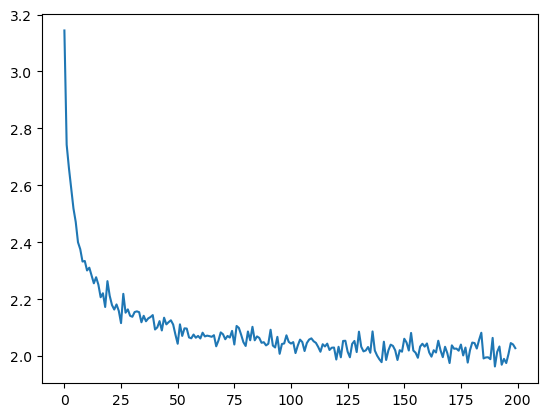

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

### Task 1:
Given a start letter and a category, generate a new word until the network outputs the end of sequence token or the word reaches 20 characters. In the first time step use the given start letter as input to the RNN. In the following time steps use the letter as input for which the RNN previously gave the highest output score.

In [12]:
max_length = 20

start_letter = "B"
category = 'German'

### Task 2:
Given several start letters and a category, generate a word until the network outputs the end of sequence token or the word reaches 20 characters. Before you start generating new letters, completely feed all start letters into the network. In the following time steps use the letter as input for which the RNN previously gave the highest output score.

In [13]:
max_length = 20

start_letters = "Mer"
category = 'German'

### Task 3:
Repeat task 2, but instead of choosing the next letter as the one with the highest output, run a softmax over the output and sample from the resulting distribution to generate the next letter.

In [14]:
max_length = 20

start_letters = "Mer"
category = 'German'